In [1]:
# ============================================================
# Cell 1: Packages
# ============================================================

using LinearAlgebra
using SparseArrays
using Statistics
using Random
using Printf
using Plots

using Parameters          # @with_kw for keyword-based mutable structs
using Distributions       # Beta etc (if needed for type distributions)
using Roots               # root finding (optional; bisection, find_zero)

In [2]:
# ============================================================
# Cell 2: Structs (keyword-based, mutable)
# ============================================================

@with_kw mutable struct Primitives
    # Discounting
    r::Float64 = 0.05

    # Aggregate CTMC
    Q::Matrix{Float64}
    zgrid::Vector{Float64}
    K::Int = length(zgrid)

    # Unskilled matching
    μU::Float64 = 0.8
    ηU::Float64 = 0.5
    kU::Float64 = 0.3
    βU::Float64 = 0.5
    λU::Float64 = 0.2

    # Training
    ϕ::Float64 = 0.3
    bU::Vector{Float64}
    bT::Vector{Float64}
    PU::Vector{Float64}

    # Worker-type distribution ℓ: x ~ Beta(ax,bx)
    ax::Float64 = 2.0
    bx::Float64 = 5.0

    # Conditional match productivity: p|x ~ Beta(aP(x), bP) on [0,1]
    # with aP(x) = aP0 + aP1*x ensuring FOSD (larger x shifts mass right)
    aP0::Float64 = 2.0
    aP1::Float64 = 6.0
    bP::Float64  = 4.0

    # Training cost
    c::Function = x -> 0.2 * (1.0 - x)^2
end

@with_kw mutable struct Grids
    Nx::Int
    Np::Int
    K::Int
    x::Vector{Float64}
    p::Vector{Float64}
end

@with_kw mutable struct Cache
    # Cost on x-grid
    c_x::Vector{Float64}              # (Nx)

    # Worker-type distribution on x-grid (ℓ)
    ell_pdf::Vector{Float64}          # (Nx) pdf evaluated at grid points
    ell_cdf::Vector{Float64}          # (Nx) cdf evaluated at grid points
    ell_w::Vector{Float64}            # (Nx) quadrature weights for ∫ h(x) ℓ(x) dx
    ell_cumw::Vector{Float64}         # (Nx) cumulative weights (prefix sums)

    # Conditional distribution G(p|x) on p-grid
    Gpdf::Matrix{Float64}             # (Nx, Np) g(p|x) evaluated on grid
    Gcdf::Matrix{Float64}             # (Nx, Np) G(p|x) evaluated on grid
    Gw::Matrix{Float64}               # (Nx, Np) weights for ∫ h(p) dG(p|x)
    Gw_tail::Matrix{Float64}          # (Nx, Np) tail weights: Σ_{j≥ip} Gw[ix,j]

    # Iteration-time derived objects (allocated now, filled later)
    EposS::Matrix{Float64}            # (Nx, K)
    train_policy::BitMatrix           # (Nx, K)
    searcher_pdf::Matrix{Float64}     # (Nx, K)
end

@with_kw mutable struct Objects
    θ::Vector{Float64}                # (K)
    xbar::Vector{Float64}             # (K)
    pstar::Matrix{Float64}            # (Nx, K)

    S::Array{Float64,3}               # (Nx, Np, K)
    Usearch::Matrix{Float64}          # (Nx, K)
    UU::Matrix{Float64}               # (Nx, K)
    T::Matrix{Float64}                # (Nx, K)
end

@with_kw mutable struct Model
    par::Primitives
    grid::Grids
    cache::Cache
    obj::Objects
end

Model

In [3]:
# ============================================================
# Cell 3: Core utilities (no placeholders)
# ============================================================

# CTMC operator: (rI - Q) * V
function ctmc_operator_apply(V::AbstractVector{<:Real},
                            Q::AbstractMatrix{<:Real},
                            r::Real)
    K = length(V)
    @assert size(Q,1) == K && size(Q,2) == K "Q must be K×K with K=length(V)."
    return (r .* Vector{Float64}(V)) .- (Matrix{Float64}(Q) * Vector{Float64}(V))
end

# Matching rates
qU(θ::Real, μU::Real, ηU::Real) = μU * θ^(-ηU)
fU_jobfind(θ::Real, μU::Real, ηU::Real) = θ * qU(θ, μU, ηU)  # μU * θ^(1-ηU)

# Trapezoid weights on any strictly increasing 1D grid
function trapezoid_weights(grid::AbstractVector{<:Real})
    n = length(grid)
    @assert n ≥ 2
    g = Vector{Float64}(grid)
    w = zeros(Float64, n)
    @inbounds begin
        w[1] = (g[2] - g[1]) / 2
        for i in 2:n-1
            w[i] = (g[i+1] - g[i-1]) / 2
        end
        w[n] = (g[n] - g[n-1]) / 2
    end
    return w
end

function build_grids(; Nx::Int, Np::Int, K::Int,
                      xmin::Float64=0.0, xmax::Float64=1.0,
                      pmin::Float64=0.0, pmax::Float64=1.0)
    @assert Nx ≥ 2 && Np ≥ 2
    x = collect(range(xmin, xmax; length=Nx))
    p = collect(range(pmin, pmax; length=Np))
    return Grids(Nx=Nx, Np=Np, K=K, x=x, p=p)
end

build_grids (generic function with 1 method)

In [4]:
# ============================================================
# Cell 4: Precompute ℓ(x) and G(p|x) including CDF tables
# ============================================================

function allocate_cache(grid::Grids)
    Nx, Np, K = grid.Nx, grid.Np, grid.K
    return Cache(
        c_x         = zeros(Float64, Nx),

        ell_pdf     = zeros(Float64, Nx),
        ell_cdf     = zeros(Float64, Nx),
        ell_w       = zeros(Float64, Nx),
        ell_cumw    = zeros(Float64, Nx),

        Gpdf        = zeros(Float64, Nx, Np),
        Gcdf        = zeros(Float64, Nx, Np),
        Gw          = zeros(Float64, Nx, Np),
        Gw_tail     = zeros(Float64, Nx, Np),

        EposS       = zeros(Float64, Nx, K),
        train_policy= falses(Nx, K),
        searcher_pdf= zeros(Float64, Nx, K),
    )
end

function precompute_cost!(m::Model)
    x = m.grid.x
    @inbounds for ix in eachindex(x)
        m.cache.c_x[ix] = Float64(m.par.c(x[ix]))
    end
    return nothing
end

# Precompute worker-type distribution ℓ: x ~ Beta(ax,bx) on [0,1]
# Produces: pdf(x_i), cdf(x_i), and quadrature weights for integrals wrt ℓ(x) dx.
function precompute_ell!(m::Model)
    x = m.grid.x
    Nx = m.grid.Nx
    dist = Beta(m.par.ax, m.par.bx)

    # pdf/cdf evaluated on grid
    @inbounds for ix in 1:Nx
        xi = x[ix]
        m.cache.ell_pdf[ix] = pdf(dist, xi)
        m.cache.ell_cdf[ix] = cdf(dist, xi)
    end

    # quadrature weights for ∫ h(x) ℓ(x) dx ≈ Σ h(x_i) * ell_w[i]
    wx = trapezoid_weights(x)               # dx weights
    @inbounds for ix in 1:Nx
        m.cache.ell_w[ix] = m.cache.ell_pdf[ix] * wx[ix]
    end

    # normalize weights to sum to 1 (so they behave like a discrete distribution)
    s = sum(m.cache.ell_w)
    @assert s > 0 "ell_w sums to 0; check grid or Beta parameters."
    m.cache.ell_w ./= s

    # cumulative weights (prefix sums)
    m.cache.ell_cumw .= cumsum(m.cache.ell_w)

    return nothing
end

# Precompute conditional distribution G(p|x): p|x ~ Beta(aP0+aP1*x, bP)
# Produces: Gcdf[ix,ip], Gpdf[ix,ip], Gw[ix,ip]=g*dp normalized, and tail weights.
function precompute_G!(m::Model)
    xgrid, pgrid = m.grid.x, m.grid.p
    Nx, Np = m.grid.Nx, m.grid.Np
    wp = trapezoid_weights(pgrid)   # dp weights

    @inbounds for ix in 1:Nx
        x = xgrid[ix]
        a = max(1e-6, m.par.aP0 + m.par.aP1 * x)  # strictly positive
        b = max(1e-6, m.par.bP)
        dist = Beta(a, b)

        for ip in 1:Np
            p = pgrid[ip]
            m.cache.Gpdf[ix, ip] = pdf(dist, p)
            m.cache.Gcdf[ix, ip] = cdf(dist, p)
            m.cache.Gw[ix, ip]   = m.cache.Gpdf[ix, ip] * wp[ip]
        end

        # normalize Gw to sum to 1 (discrete approximation to dG)
        s = sum(@view m.cache.Gw[ix, :])
        @assert s > 0 "Gw sums to 0; check Beta parameters or p-grid."
        @views m.cache.Gw[ix, :] ./= s

        # tail weights Gw_tail[ix, ip] = Σ_{j=ip:} Gw[ix,j]
        # computed by reverse cumulative sum
        @views begin
            m.cache.Gw_tail[ix, Np] = m.cache.Gw[ix, Np]
            for ip in (Np-1):-1:1
                m.cache.Gw_tail[ix, ip] = m.cache.Gw[ix, ip] + m.cache.Gw_tail[ix, ip+1]
            end
        end
    end

    return nothing
end

precompute_G! (generic function with 1 method)

In [5]:
# ============================================================
# Cell 5: initialize_model (allocates + runs precomputations)
# ============================================================

function allocate_objects(grid::Grids; θ0::Union{Nothing,Vector{Float64}}=nothing)
    Nx, Np, K = grid.Nx, grid.Np, grid.K
    θ_init = θ0 === nothing ? fill(0.5, K) : copy(θ0)
    return Objects(
        θ      = θ_init,
        xbar   = fill(0.5, K),
        pstar  = fill(0.0, Nx, K),

        S      = zeros(Float64, Nx, Np, K),
        Usearch= zeros(Float64, Nx, K),
        UU     = zeros(Float64, Nx, K),
        T      = zeros(Float64, Nx, K),
    )
end

function initialize_model(; Q::Matrix{Float64}, zgrid::Vector{Float64},
                           PU::Vector{Float64}, bU::Vector{Float64}, bT::Vector{Float64},
                           r::Float64=0.05,
                           μU::Float64=0.8, ηU::Float64=0.5, kU::Float64=0.3, βU::Float64=0.5, λU::Float64=0.2,
                           ϕ::Float64=0.3,
                           ax::Float64=2.0, bx::Float64=5.0,
                           aP0::Float64=2.0, aP1::Float64=6.0, bP::Float64=4.0,
                           c::Function = x -> 0.2 * (1.0 - x)^2,
                           Nx::Int=41, Np::Int=51,
                           θ0::Union{Nothing,Vector{Float64}}=nothing)

    K = length(zgrid)
    @assert size(Q,1) == K && size(Q,2) == K
    @assert length(PU) == K && length(bU) == K && length(bT) == K

    grid = build_grids(Nx=Nx, Np=Np, K=K)
    par = Primitives(r=r, Q=Q, zgrid=zgrid, K=K,
                     μU=μU, ηU=ηU, kU=kU, βU=βU, λU=λU,
                     ϕ=ϕ, bU=bU, bT=bT, PU=PU,
                     ax=ax, bx=bx,
                     aP0=aP0, aP1=aP1, bP=bP,
                     c=c)

    cache = allocate_cache(grid)
    obj   = allocate_objects(grid; θ0=θ0)

    m = Model(par=par, grid=grid, cache=cache, obj=obj)

    # Precomputations (only once)
    precompute_cost!(m)
    precompute_ell!(m)
    precompute_G!(m)

    return m
end

initialize_model (generic function with 1 method)

In [6]:
# ============================================================
# Cell 6: Inner loop (surplus iteration + pstar update)
# ============================================================

# EposS[ix,z] = E_p[ max(0, S(p,x,z)) | x ] using precomputed Gw[ix,ip]
function expected_pos_surplus_by_xz!(m::Model)
    Nx, Np, K = m.grid.Nx, m.grid.Np, m.grid.K
    S  = m.obj.S
    Gw = m.cache.Gw
    EposS = m.cache.EposS
    fill!(EposS, 0.0)

    @inbounds for ix in 1:Nx
        for ip in 1:Np
            w = Gw[ix, ip]
            if w == 0.0
                continue
            end
            for z in 1:K
                s = S[ix, ip, z]
                if s > 0.0
                    EposS[ix, z] += w * s
                end
            end
        end
    end
    return nothing
end

# Update reservation productivity pstar[ix,z] from S grid:
# pstar is the (approx) smallest p such that S(p,x,z) >= 0.
# Linear interpolation between neighboring grid points.
function update_pstar_from_S!(m::Model)
    Nx, Np, K = m.grid.Nx, m.grid.Np, m.grid.K
    pgrid = m.grid.p
    S = m.obj.S
    pstar = m.obj.pstar

    @inbounds for z in 1:K
        for ix in 1:Nx
            # Find first ip with nonnegative surplus
            ip0 = 0
            for ip in 1:Np
                if S[ix, ip, z] >= 0.0
                    ip0 = ip
                    break
                end
            end

            if ip0 == 0
                # always negative => reservation above max; clamp to pmax
                pstar[ix, z] = pgrid[end]
            elseif ip0 == 1
                # already nonnegative at pmin
                pstar[ix, z] = pgrid[1]
            else
                # interpolate between ip0-1 (negative) and ip0 (nonnegative)
                pL = pgrid[ip0-1]; pH = pgrid[ip0]
                sL = S[ix, ip0-1, z]; sH = S[ix, ip0, z]
                if sH == sL
                    pstar[ix, z] = pH
                else
                    # solve s(p)=0 by linear interpolation
                    pstar[ix, z] = pL + (0.0 - sL) * (pH - pL) / (sH - sL)
                end
            end
        end
    end
    return nothing
end

# Main inner loop: given current θ (not directly used here), UU, solve for S and pstar.
#
# Surplus equation (discrete-time analog in continuous time with CTMC):
#   ((rI - Q) + λU) S(p,x,·) = PU(·)*p - (rI - Q)UU(x,·) + λU * EposS(x,·)
#
# where EposS(x,z) = E_p'[ max(0,S(p',x,z)) | x ].
function solve_surplus_inner!(m::Model; maxiter::Int=500, tol::Float64=1e-8, damp::Float64=0.9, verbose::Bool=false)
    par = m.par
    grid = m.grid
    Nx, Np, K = grid.Nx, grid.Np, grid.K
    Q = par.Q
    r = par.r
    λ = par.λU

    # Pre-factorize A = (r+λ)I - Q once (K×K)
    A = (r + λ) * I(K) - Q
    F = lu(Matrix(A))

    # Work buffers (avoid allocs in hot loops)
    rhs = zeros(Float64, K)
    AUU = zeros(Float64, K)     # (rI - Q)UU(x,·)
    Snew_vec = zeros(Float64, K)

    S = m.obj.S
    UU = m.obj.UU
    EposS = m.cache.EposS
    pgrid = grid.p
    PU = par.PU

    # initialize EposS based on current S
    expected_pos_surplus_by_xz!(m)

    # Fixed point on S
    diff = Inf
    it = 0

    while it < maxiter && diff > tol
        it += 1
        diff = 0.0

        # For each x, compute (rI - Q)UU(x,·) once, then solve per p
        @inbounds for ix in 1:Nx
            # AUU = (rI - Q) * UU[ix,:]
            AUU .= ctmc_operator_apply(@view(UU[ix, :]), Q, r)

            for ip in 1:Np
                p = pgrid[ip]

                # rhs(z) = PU[z]*p - AUU[z] + λ * EposS[ix,z]
                for z in 1:K
                    rhs[z] = PU[z] * p - AUU[z] + λ * EposS[ix, z]
                end

                # Solve for Snew_vec: A * S = rhs
                Snew_vec .= F \ rhs

                # Damped update and track sup norm
                for z in 1:K
                    old = S[ix, ip, z]
                    new = damp * Snew_vec[z] + (1.0 - damp) * old
                    S[ix, ip, z] = new
                    d = abs(new - old)
                    if d > diff
                        diff = d
                    end
                end
            end
        end

        # Update EposS using the new S for the next iteration
        expected_pos_surplus_by_xz!(m)

        if verbose && (it == 1 || it % 25 == 0)
            @printf("  inner it=%d  supdiff=%.3e\n", it, diff)
        end
    end

    # Update pstar from the converged S
    update_pstar_from_S!(m)

    if verbose
        @printf("  inner done: it=%d  supdiff=%.3e\n", it, diff)
    end

    return nothing
end

solve_surplus_inner! (generic function with 1 method)

In [7]:
# ============================================================
# Cell 7: Minimal run test for the inner loop
# ============================================================

# Reproducibility
Random.seed!(1234)

# --- Aggregate CTMC (K=3 states: low/normal/high) ---
zgrid = [0.75, 1.0, 1.25]  # labels only

# Generator: switch at intensity 0.10 in either direction
Q = [-0.10  0.10  0.00;
      0.10 -0.20  0.10;
      0.00  0.10 -0.10]

# Sector productivity shifter in unskilled market by state
PU = [0.75, 1.0, 1.25]

# Flow payoffs by state
bU = [0.30, 0.35, 0.40]
bT = [0.25, 0.30, 0.35]

# --- Initialize model (small grids for a quick smoke test) ---
m = initialize_model(
    Q=Q, zgrid=zgrid, PU=PU, bU=bU, bT=bT,
    r=0.05,
    μU=0.8, ηU=0.4, kU=0.3, βU=0.5, λU=0.2,
    ϕ=0.3,
    ax=2.0, bx=5.0,
    aP0=2.0, aP1=6.0, bP=4.0,
    c = x -> 0.2 * (1.0 - x)^2,
    Nx=21, Np=31
)

# Ensure UU is initialized (it is zeros by default; keep explicit for clarity)
fill!(m.obj.UU, 0.0)

# Optional: initialize S with something nonzero to see convergence behavior
# (not required; zeros works)
fill!(m.obj.S, 0.0)

println("Running inner loop (surplus iteration)...")
solve_surplus_inner!(m; maxiter=300, tol=1e-9, damp=0.9, verbose=true)

# --- Quick diagnostics ---
println("\nDiagnostics:")

# Check a few surplus values at mid x and a few p points
ix_mid = Int(cld(m.grid.Nx, 2))
ips = [1, Int(cld(m.grid.Np, 2)), m.grid.Np]

for z in 1:m.grid.K
    println("\nState z=$z (PU=$(m.par.PU[z])):")
    @printf("  x_mid=%.3f  pstar=%.4f\n", m.grid.x[ix_mid], m.obj.pstar[ix_mid, z])
    for ip in ips
        @printf("  p=%.3f  S=%.6f\n", m.grid.p[ip], m.obj.S[ix_mid, ip, z])
    end
end

# Sanity: EposS should be nonnegative (up to numerical noise)
mn = minimum(m.cache.EposS)
mx = maximum(m.cache.EposS)
@printf("\nEposS range: [%.3e, %.3e]\n", mn, mx)

# Sanity: pstar in [0,1]
pmin = minimum(m.obj.pstar)
pmax = maximum(m.obj.pstar)
@printf("pstar range: [%.4f, %.4f]\n", pmin, pmax)

Running inner loop (surplus iteration)...
  inner it=1  supdiff=4.243e+00
  inner it=25  supdiff=2.050e-02
  inner it=50  supdiff=1.436e-04
  inner it=75  supdiff=1.006e-06
  inner it=100  supdiff=7.043e-09
  inner done: it=110  supdiff=9.681e-10

Diagnostics:

State z=1 (PU=0.75):
  x_mid=0.500  pstar=0.0000
  p=0.000  S=8.359807
  p=0.500  S=10.002665
  p=1.000  S=11.645522

State z=2 (PU=1.0):
  x_mid=0.500  pstar=0.0000
  p=0.000  S=8.888909
  p=0.500  S=10.888909
  p=1.000  S=12.888909

State z=3 (PU=1.25):
  x_mid=0.500  pstar=0.0000
  p=0.000  S=9.418011
  p=0.500  S=11.775154
  p=1.000  S=14.132297

EposS range: [6.122e+00, 1.444e+01]
pstar range: [0.0000, 0.0000]


In [8]:
# ============================================================
# Cell 8: Outer loop (Usearch, T, xbar, UU, searcher composition, θ update)
# ============================================================

# ----------------------------
# Worker-side: solve Usearch(x,z)
# (r - Q) Usearch = bU + f(θ) * βU * EposS
# ----------------------------
function solve_Usearch!(m::Model)
    par, grid = m.par, m.grid
    Nx, K = grid.Nx, grid.K
    Q, r = par.Q, par.r

    Usearch = m.obj.Usearch
    EposS   = m.cache.EposS

    # For each x, solve K×K linear system: (rI - Q) U = bU + f(θ(z))*βU*EposS(x,z)
    A = r * I(K) - Q
    F = lu(Matrix(A))

    rhs = zeros(Float64, K)

    @inbounds for ix in 1:Nx
        for z in 1:K
            rhs[z] = par.bU[z] + fU_jobfind(m.obj.θ[z], par.μU, par.ηU) * par.βU * EposS[ix, z]
        end
        Usearch[ix, :] .= F \ rhs
    end
    return nothing
end

# ----------------------------
# Training value T(x,z)
# For now: (r - Q + ϕ)T = bT  (since U_S not yet implemented)
# ----------------------------
function solve_training_value!(m::Model)
    par, grid = m.par, m.grid
    Nx, K = grid.Nx, grid.K
    Q, r, ϕ = par.Q, par.r, par.ϕ

    T = m.obj.T
    A = (r + ϕ) * I(K) - Q
    F = lu(Matrix(A))

    rhs = Vector{Float64}(undef, K)

    @inbounds for ix in 1:Nx
        for z in 1:K
            rhs[z] = par.bT[z]     # + ϕ*U_S(x,z) would go here later
        end
        T[ix, :] .= F \ rhs
    end
    return nothing
end

# ----------------------------
# xbar(z): smallest x such that -c(x)+T(x,z) >= Usearch(x,z)
# Also fills train_policy[ix,z] boolean on the grid.
# ----------------------------
function update_xbar!(m::Model)
    grid, par = m.grid, m.par
    Nx, K = grid.Nx, grid.K
    xgrid = grid.x

    Usearch = m.obj.Usearch
    T       = m.obj.T
    c_x     = m.cache.c_x

    xbar = m.obj.xbar
    pol  = m.cache.train_policy

    @inbounds for z in 1:K
        # find first ix where training weakly dominates search
        ix0 = 0
        for ix in 1:Nx
            train_val = -c_x[ix] + T[ix, z]
            if train_val >= Usearch[ix, z]
                ix0 = ix
                break
            end
        end

        if ix0 == 0
            # nobody trains
            xbar[z] = 1.0
        elseif ix0 == 1
            # everyone trains
            xbar[z] = 0.0
        else
            # linear interpolation for indifference between ix0-1 and ix0
            xL, xH = xgrid[ix0-1], xgrid[ix0]
            dL = (-c_x[ix0-1] + T[ix0-1, z]) - Usearch[ix0-1, z]
            dH = (-c_x[ix0]   + T[ix0, z])   - Usearch[ix0, z]
            if dH == dL
                xbar[z] = xH
            else
                xbar[z] = xL + (0.0 - dL) * (xH - xL) / (dH - dL)
                xbar[z] = clamp(xbar[z], 0.0, 1.0)
            end
        end

        # fill policy on grid
        for ix in 1:Nx
            pol[ix, z] = (xgrid[ix] >= xbar[z])
        end
    end

    return nothing
end

# ----------------------------
# Construct UU(x,z) from cutoff rule
# ----------------------------
function construct_UU!(m::Model)
    Nx, K = m.grid.Nx, m.grid.K
    UU = m.obj.UU
    Usearch = m.obj.Usearch
    T = m.obj.T
    c_x = m.cache.c_x
    pol = m.cache.train_policy

    @inbounds for ix in 1:Nx
        for z in 1:K
            if pol[ix, z]
                UU[ix, z] = -c_x[ix] + T[ix, z]
            else
                UU[ix, z] = Usearch[ix, z]
            end
        end
    end
    return nothing
end

# ----------------------------
# Compute searcher composition weights tildeℓ(x|z) over the x-grid
# Using precomputed ℓ weights ell_w and the cutoff rule (search iff x < xbar).
# Produces cache.searcher_pdf[ix,z] summing to 1 for each z (if any searchers).
# ----------------------------
function compute_searcher_weights!(m::Model)
    grid = m.grid
    Nx, K = grid.Nx, grid.K
    xgrid = grid.x
    ell_w = m.cache.ell_w

    w = m.cache.searcher_pdf
    fill!(w, 0.0)

    @inbounds for z in 1:K
        xb = m.obj.xbar[z]
        s = 0.0
        for ix in 1:Nx
            if xgrid[ix] < xb
                w[ix, z] = ell_w[ix]
                s += w[ix, z]
            end
        end
        if s > 0
            for ix in 1:Nx
                w[ix, z] /= s
            end
        else
            # if nobody searches, keep all zeros (job creation residual will handle)
            # (You can also set uniform tiny mass, but that distorts equilibrium.)
        end
    end
    return nothing
end

# ----------------------------
# Job creation residual: kU - q(θ) * E_x[(1-β) * EposS(x,z)] over searchers
# If no searchers in state z, returns +kU (cannot create jobs without applicants).
# ----------------------------
function job_creation_residual(θ::Real, z::Int, m::Model)
    par = m.par
    Nx = m.grid.Nx

    q = qU(θ, par.μU, par.ηU)
    w = m.cache.searcher_pdf
    EposS = m.cache.EposS

    # If no searchers, residual stays positive
    mass = 0.0
    acc  = 0.0
    @inbounds for ix in 1:Nx
        wi = w[ix, z]
        mass += wi
        acc  += wi * EposS[ix, z]
    end
    if mass == 0.0
        return par.kU
    end

    return par.kU - q * (1.0 - par.βU) * acc
end

# ----------------------------
# θ update in each z by bisection on job_creation_residual(θ,z)
# ----------------------------
function update_theta!(m::Model; θmin::Float64=1e-6, θmax::Float64=200.0, tol::Float64=1e-10, maxit::Int=200)
    K = m.grid.K

    for z in 1:K
        f_lo = job_creation_residual(θmin, z, m)
        f_hi = job_creation_residual(θmax, z, m)

        # If residual is positive everywhere => no-solution => θ = θmin (no posting)
        if f_lo > 0.0 && f_hi > 0.0
            m.obj.θ[z] = θmin
            continue
        end

        # If residual is negative everywhere => no-solution => θ = θmax
        if f_lo < 0.0 && f_hi < 0.0
            m.obj.θ[z] = θmax
            continue
        end

        # We have a sign change: bisection
        a, b = θmin, θmax
        fa, fb = f_lo, f_hi

        for _ in 1:maxit
            mid = 0.5 * (a + b)
            fm  = job_creation_residual(mid, z, m)

            if abs(fm) < tol || (b - a) < tol * (1.0 + mid)
                m.obj.θ[z] = mid
                break
            end

            # residual is increasing in θ (since q decreases in θ)
            if fm > 0.0
                b = mid
            else
                a = mid
            end
            m.obj.θ[z] = 0.5 * (a + b)
        end
    end

    return nothing
end

# ----------------------------
# Full unskilled-market solver (outer fixed point)
# Iterates {S, pstar, Usearch, T, xbar, UU, searcher_pdf, θ}
# ----------------------------
function solve_unskilled_market!(m::Model;
                                max_outer::Int=200,
                                tol_outer::Float64=1e-6,
                                damp_theta::Float64=0.5,
                                verbose::Bool=true)

    K = m.grid.K
    θ_old   = copy(m.obj.θ)
    xbar_old= copy(m.obj.xbar)
    pstar_old = copy(m.obj.pstar)

    for it in 1:max_outer
        # 1) Inner loop: given UU (from last outer iter), solve S and pstar
        solve_surplus_inner!(m; maxiter=500, tol=1e-8, damp=0.9, verbose=false)

        # 2) Expectations from surplus
        expected_pos_surplus_by_xz!(m)

        # 3) Worker-side: Usearch and training, cutoff, UU
        solve_Usearch!(m)
        solve_training_value!(m)
        update_xbar!(m)
        construct_UU!(m)

        # 4) Searcher composition implied by cutoff
        compute_searcher_weights!(m)

        # 5) Update θ from free entry
        θ_new = copy(m.obj.θ)
        update_theta!(m; θmin=1e-4, θmax=200.0, tol=1e-10, maxit=200)
        θ_new .= m.obj.θ

        # Damping on θ for stability
        @inbounds for z in 1:K
            m.obj.θ[z] = damp_theta * θ_new[z] + (1.0 - damp_theta) * θ_old[z]
        end

        # 6) Convergence diagnostics
        dθ = maximum(abs.(m.obj.θ .- θ_old))
        dx = maximum(abs.(m.obj.xbar .- xbar_old))
        dp = maximum(abs.(m.obj.pstar .- pstar_old))
        d  = max(dθ, max(dx, dp))

        if verbose && (it == 1 || it % 10 == 0)
            @printf("outer it=%d  maxΔ=%.3e  (Δθ=%.3e, Δxbar=%.3e, Δp*=%.3e)\n", it, d, dθ, dx, dp)
        end

        if d < tol_outer
            if verbose
                println("Outer loop converged.")
            end
            return nothing
        end

        θ_old    .= m.obj.θ
        xbar_old .= m.obj.xbar
        pstar_old.= m.obj.pstar
        
        # Check A(z) = E_x[ EposS | searchers ] and searcher mass
        for z in 1:m.grid.K
            mass = sum(m.cache.searcher_pdf[:,z])
            A = sum(m.cache.searcher_pdf[:,z] .* m.cache.EposS[:,z])
            @printf("z=%d: searcher_mass=%.6f  A(z)=%.6e  residual(θ)=%.6f\n",
                    z, mass, A, job_creation_residual(m.obj.θ[z], z, m))
        end
        
    end

    if verbose
        println("Outer loop reached max_outer without full convergence.")
    end
    return nothing
end

# Top-level (for now): solve unskilled market only
function solve_model!(m::Model; verbose::Bool=true)
    # Ensure UU exists sensibly at start
    # Use Usearch (initialized zeros) vs training (-c + T initialized zeros) cutoff;
    # a simple default is UU=Usearch=0 at initialization, which is fine.
    solve_unskilled_market!(m; verbose=verbose)
    return nothing
end

solve_model! (generic function with 1 method)

In [13]:
# ============================================================
# Cell 9: Smoke test / example run (unskilled market outer loop)
# ============================================================

# Reproducibility
Random.seed!(1234)

# --- Aggregate CTMC (K=3 states: low/normal/high) ---
zgrid = [0.75, 1.0 , 1.25]  # labels only

# Generator: switch at intensity 0.10 in either direction
Q = [-0.10  0.10  0.00;
      0.10 -0.20  0.10;
      0.00  0.10 -0.10]

# Sector productivity shifter in unskilled market by state
PU = [0.75, 1.0, 1.25]

# Flow payoffs by state
bU = [0.30, 0.35, 0.40]   # unskilled unemployment flow payoff
bT = [0.25, 0.30, 0.35]   # training flow payoff

# --- Initialize model ---
m = initialize_model(
    Q=Q, zgrid=zgrid, PU=PU, bU=bU, bT=bT,
    # Preferences/technology
    r=0.05,
    μU=0.8, ηU=0.2, kU=0.3, βU=0.5, λU=0.2,
    ϕ=0.3,
    # Distributions
    ax=2.0, bx=5.0,
    aP0=2.0, aP1=6.0, bP=4.0,
    # Cost
    c = x -> 0.2 * (1.0 - x)^2,
    # Grids (sensible for a smoke test)
    Nx=31, Np=41
)

# Optional: initial guess for θ (otherwise defaults to 0.5 in each state)
m.obj.θ .= [0.8, 1.0, 1.2]

# --- Solve ---
solve_model!(m; verbose=true)

# --- Report key outcomes ---
println("\nConverged objects (unskilled market):")
println("θ(z):   ", m.obj.θ)
println("xbar(z):", m.obj.xbar)

# Show a few p*(x,z) values
ixs = [1, Int(round(m.grid.Nx/2)), m.grid.Nx]
for z in 1:m.grid.K
    println("\nState z=$z:")
    for ix in ixs
        @printf("  x=%.3f  p*(x,z)=%.4f\n", m.grid.x[ix], m.obj.pstar[ix, z])
    end
end

# Check free entry residuals at the converged θ
println("\nFree entry residual check (should be near 0):")
for z in 1:m.grid.K
    res = job_creation_residual(m.obj.θ[z], z, m)
    @printf("  z=%d  residual=%.3e\n", z, res)
end

# A couple of quick sanity checks
@printf("\nEposS range: [%.3e, %.3e]\n", minimum(m.cache.EposS), maximum(m.cache.EposS))
@printf("pstar range: [%.4f, %.4f]\n", minimum(m.obj.pstar), maximum(m.obj.pstar))

outer it=1  maxΔ=9.960e+01  (Δθ=9.960e+01, Δxbar=5.000e-01, Δp*=0.000e+00)
z=1: searcher_mass=1.000000  A(z)=8.692999e+00  residual(θ)=-1.083193
z=2: searcher_mass=1.000000  A(z)=9.483272e+00  residual(θ)=-1.208638
z=3: searcher_mass=1.000000  A(z)=1.027354e+01  residual(θ)=-1.334033
z=1: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=2: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=3: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=1: searcher_mass=1.000000  A(z)=2.066594e+00  residual(θ)=-0.026192
z=2: searcher_mass=1.000000  A(z)=2.516707e+00  residual(θ)=-0.083199
z=3: searcher_mass=1.000000  A(z)=2.968844e+00  residual(θ)=-0.152024
z=1: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=2: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=3: searcher_mass=1.000000  A(z)=0.000000e+00  residual(θ)=0.300000
z=1: searcher_mass=1.000000  A(z)=2.066594e+00  residual(θ)=-0.025553
z=2: searcher_mass=1.

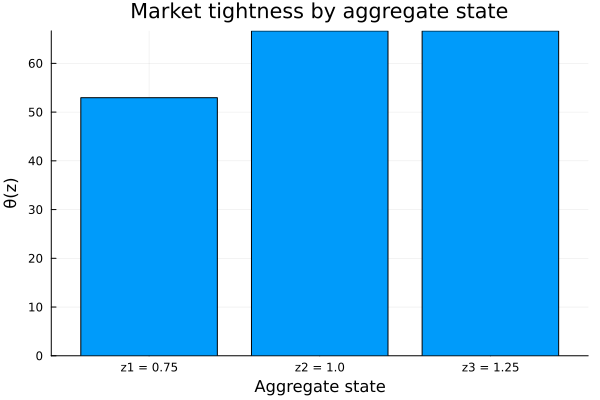

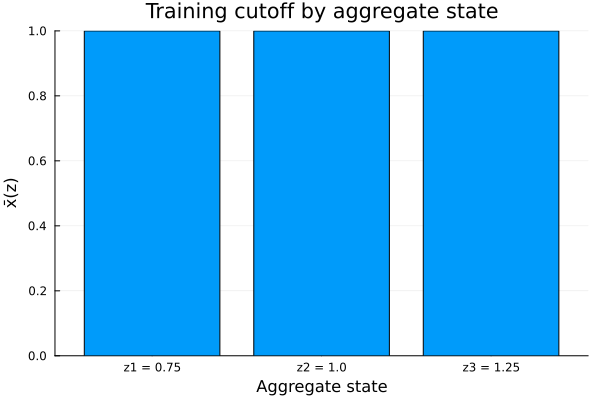

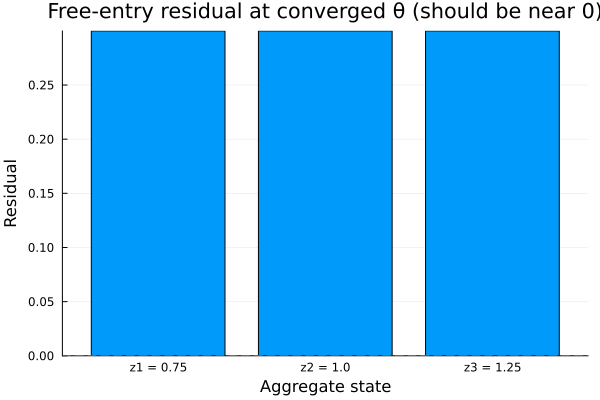

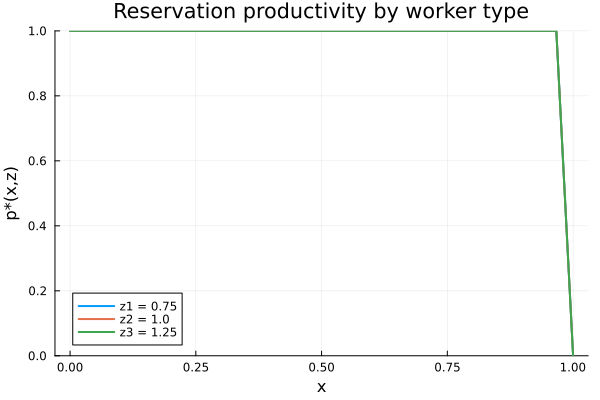

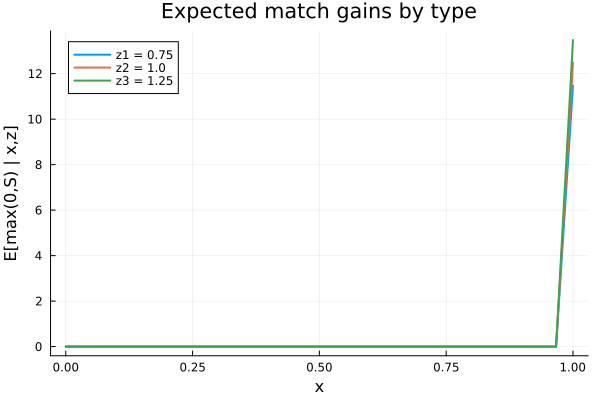

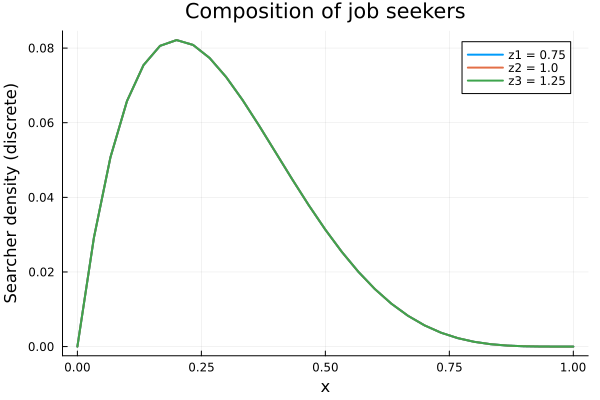

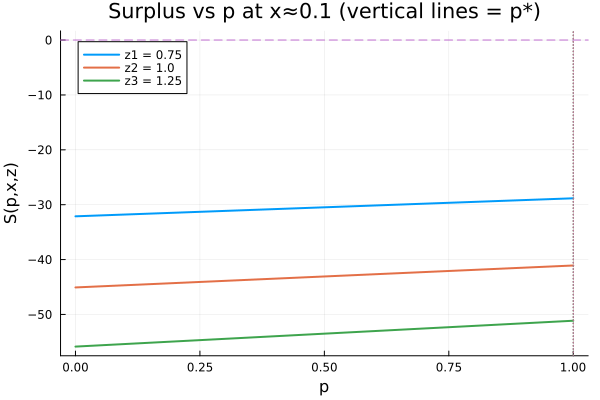

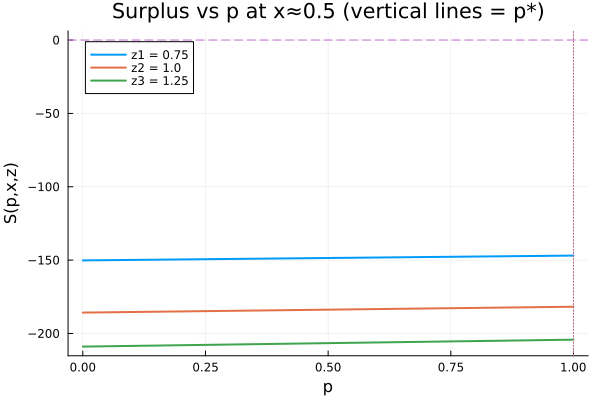

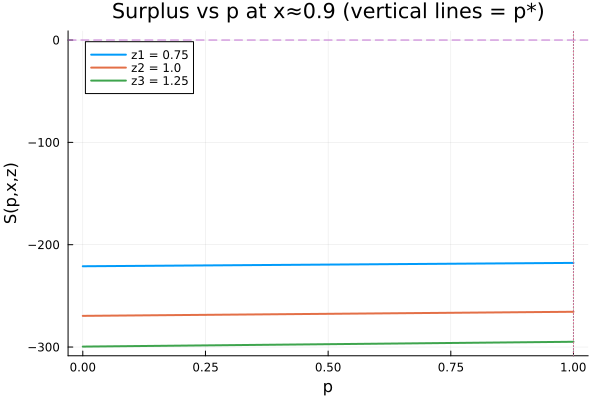

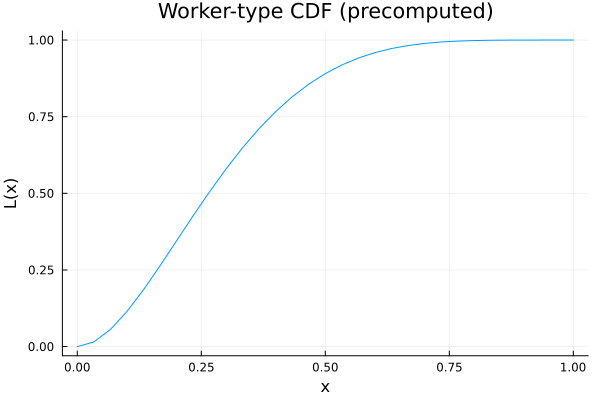

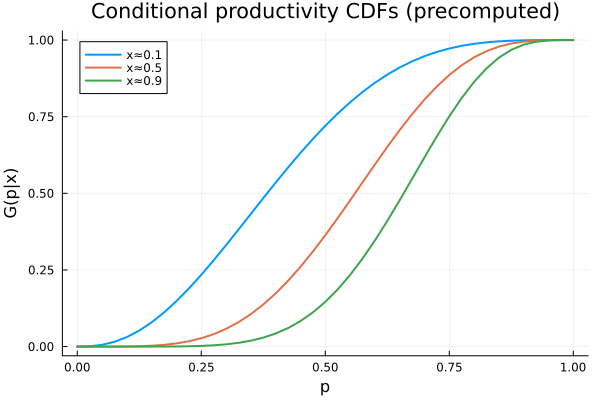

In [10]:
# ============================================================
# Cell 11: Interesting plots (diagnostics + economics)
# ============================================================
# ============================================================
# Helper functions for plotting
# ============================================================

# Nearest grid index helper
nearest_index(grid::AbstractVector{<:Real}, val::Real) =
    argmin(abs.(grid .- val))

# Pretty labels for aggregate states
function zlabels(m::Model)
    return ["z$(k) = $(round(m.par.zgrid[k], digits=2))"
            for k in 1:m.grid.K]
end
# ============================================================
# Plots
# ============================================================
# 1) Market tightness θ(z) and training cutoff xbar(z)
let
    labs = zlabels(m)
    p1 = bar(1:m.grid.K, m.obj.θ; legend=false, xticks=(1:m.grid.K, labs),
             xlabel="Aggregate state", ylabel="θ(z)", title="Market tightness by aggregate state")
    p2 = bar(1:m.grid.K, m.obj.xbar; legend=false, xticks=(1:m.grid.K, labs),
             xlabel="Aggregate state", ylabel="x̄(z)", title="Training cutoff by aggregate state")
    display(p1)
    display(p2)
end

# 2) Free-entry residual check at converged θ(z)
let
    labs = zlabels(m)
    res = [job_creation_residual(m.obj.θ[z], z, m) for z in 1:m.grid.K]
    p = bar(1:m.grid.K, res; legend=false, xticks=(1:m.grid.K, labs),
            xlabel="Aggregate state", ylabel="Residual",
            title="Free-entry residual at converged θ (should be near 0)")
    hline!([0.0]; linestyle=:dash)
    display(p)
end

# 3) Reservation productivity p*(x,z) as a function of x (one line per z)
let
    x = m.grid.x
    p = plot(x, m.obj.pstar[:,1]; label=zlabels(m)[1],
             xlabel="x", ylabel="p*(x,z)", title="Reservation productivity by worker type",
             linewidth=2)
    for z in 2:m.grid.K
        plot!(x, m.obj.pstar[:,z]; label=zlabels(m)[z], linewidth=2)
    end
    ylims!(0.0, 1.0)
    display(p)
end

# 4) Expected positive surplus E[max(0,S)|x,z] vs x (one line per z)
let
    x = m.grid.x
    p = plot(x, m.cache.EposS[:,1]; label=zlabels(m)[1],
             xlabel="x", ylabel="E[max(0,S) | x,z]", title="Expected match gains by type",
             linewidth=2)
    for z in 2:m.grid.K
        plot!(x, m.cache.EposS[:,z]; label=zlabels(m)[z], linewidth=2)
    end
    display(p)
end

# 5) Searcher composition \tilde{ℓ}(x|z) (selection into search)
let
    x = m.grid.x
    p = plot(x, m.cache.searcher_pdf[:,1]; label=zlabels(m)[1],
             xlabel="x", ylabel="Searcher density (discrete)", title="Composition of job seekers",
             linewidth=2)
    for z in 2:m.grid.K
        plot!(x, m.cache.searcher_pdf[:,z]; label=zlabels(m)[z], linewidth=2)
    end
    display(p)
end

# 6) Surplus curves S(p,x,z) as function of p for selected x's, with p*(x,z) marked
let
    pgrid = m.grid.p
    xs = [0.10, 0.50, 0.90]                         # pick interesting worker types
    ixs = [nearest_index(m.grid.x, x0) for x0 in xs] # nearest indices on grid
    labs = zlabels(m)

    for (k, ix) in enumerate(ixs)
        xval = m.grid.x[ix]
        plt = plot(pgrid, m.obj.S[ix, :, 1]; label=labs[1],
                   xlabel="p", ylabel="S(p,x,z)",
                   title="Surplus vs p at x≈$(round(xval,digits=3)) (vertical lines = p*)",
                   linewidth=2)
        # other z
        for z in 2:m.grid.K
            plot!(pgrid, m.obj.S[ix, :, z]; label=labs[z], linewidth=2)
        end
        # zero line
        hline!([0.0]; linestyle=:dash, label=false)

        # mark p*(x,z) as vertical lines (one per z)
        for z in 1:m.grid.K
            vline!([m.obj.pstar[ix, z]]; linestyle=:dot, label=false)
        end

        display(plt)
    end
end

# 7) CDF plots you explicitly asked to precompute: L(x) and G(p|x) at a few x's
let
    # Worker-type CDF L(x)
    px = plot(m.grid.x, m.cache.ell_cdf; legend=false,
              xlabel="x", ylabel="L(x)", title="Worker-type CDF (precomputed)")
    display(px)

    # Conditional productivity CDFs G(p|x) for a few x values
    pgrid = m.grid.p
    xs = [0.10, 0.50, 0.90]
    ixs = [nearest_index(m.grid.x, x0) for x0 in xs]
    pg = plot(xlabel="p", ylabel="G(p|x)", title="Conditional productivity CDFs (precomputed)")
    for (x0, ix) in zip(xs, ixs)
        plot!(pgrid, m.cache.Gcdf[ix, :]; label="x≈$(round(m.grid.x[ix],digits=3))", linewidth=2)
    end
    display(pg)
end